In [30]:
!pip install matplotlib
!pip install seaborn
!pip install scipy
!pip install scikit-learn
!pip install geopandas


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\MRHN\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\MRHN\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\MRHN\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\MRHN\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\MRHN\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [31]:
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import geopandas as gpd
cl = pd.read_csv('click_stream_new.csv')
cus = pd.read_csv('customer.csv')
proorig = pd.read_csv('product.csv', sep='\t')
tra =  pd.read_csv('transaction_new.csv')
withdraw = pd.read_csv('cus_withdraw_new.csv', encoding='latin1')
grade = pd.read_csv('cus_grade_new.csv')


C:\Users\MRHN\AppData\Local\Temp\ipykernel_30388\327859176.py:19: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  withdraw = pd.read_csv('cus_withdraw_new.csv', encoding='latin1')


In [32]:
#pro 데이터프레임 정상화
pro = proorig.T
pro = pro.reset_index()
pro = pro.T
pro = pro.iloc[:, 0].str.split(',', expand=True)
pro.iloc[0,9] = 'productDisplayName1'
pro.iloc[0,10] = 'productDisplayName2'
pro.iloc[0,11] = 'productDisplayName3'
pro.columns = pro.iloc[0]
pro = pro[1:]

In [33]:
# 필요한 데이터만 남기고 제거
cus_fil = cus[['customer_id', 'gender', 'device_type', 'birthdate', 'first_join_date', 'home_location']]
tra_fil = tra[['customer_id', 'created_at', 'payment_method', 'payment_status', 'promo_amount', 'promo_code', 'shipment_fee', 'shipment_date_limit', 'total_amount', 'quantity', 'item_price']]
filtered = cus_fil.merge(tra_fil, on='customer_id', how='inner')
filtered = filtered[filtered['payment_status'] == 'Success']
filtered.drop('payment_status', axis = 1, inplace = True)

In [34]:
filtered_copy = filtered.copy()

# 결측치 처리
filtered_copy.promo_code.fillna('no_promo', inplace=True)

# 데이터프레임의 object 타입인 컬럼들을 선택
object_columns = filtered_copy.select_dtypes(include=['object']).columns

# OrdinalEncoder 객체 생성
encoder = OrdinalEncoder()

# 선택한 컬럼들에 대해 오디널 인코딩 수행
filtered_copy[object_columns] = encoder.fit_transform(filtered_copy[object_columns])

C:\Users\MRHN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


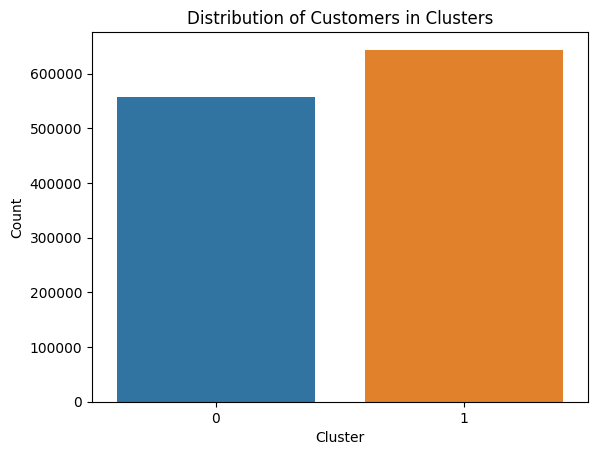

In [35]:
# customer_id 컬럼 제거 (클러스터링에서 사용하지 않음)
data_for_clustering = filtered_copy[['first_join_date', 'created_at', 'quantity']]

# 데이터 표준화
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

# K-Means 모델 생성
num_clusters = 2  # 클러스터 개수 설정
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(scaled_data)

# 클러스터 할당 결과를 데이터프레임에 추가
filtered['cluster'] = kmeans.labels_

# 클러스터별 분포 시각화
sns.countplot(data=filtered, x='cluster')
plt.title('Distribution of Customers in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

In [36]:
# customer_id 별로 그룹화 후 cluster 값의 유니크한 개수를 확인
grouped = filtered.groupby('customer_id')['cluster'].nunique()

# customer_id가 동일하면서 다른 cluster를 가지는 경우 필터링
differing_clusters = grouped[grouped > 1]

# 결과 출력
print(len(differing_clusters))
print(filtered.customer_id.nunique())

16319
50242


In [37]:
# 클러스터링 결과 양쪽 특성을 복수로 가진 데이터 제거
notusedata = differing_clusters.reset_index().customer_id.tolist()
filtered = filtered[~filtered['customer_id'].isin(notusedata)]

In [38]:
filtered

,customer_id,gender,device_type,birthdate,first_join_date,home_location,created_at,payment_method,promo_amount,promo_code,shipment_fee,shipment_date_limit,total_amount,quantity,item_price,cluster
0,7279,M,iOS,1989-01-23,2020-08-23,Nusa Tenggara Barat,2020-08-23T12:53:12.916342Z,LinkAja,2853,WEEKENDSERU,15000,2020-08-26T05:14:04.908999Z,844751,1,305982,0
1,7279,M,iOS,1989-01-23,2020-08-23,Nusa Tenggara Barat,2020-08-23T12:53:12.916342Z,LinkAja,2853,WEEKENDSERU,15000,2020-08-26T05:14:04.908999Z,844751,2,263311,0
2,7279,M,iOS,1989-01-23,2020-08-23,Nusa Tenggara Barat,2020-08-31T13:34:59.916342Z,LinkAja,0,NaN,10000,2020-09-04T05:49:01.977704Z,391341,1,381341,0
3,7279,M,iOS,1989-01-23,2020-08-23,Nusa Tenggara Barat,2020-09-08T13:38:30.916342Z,LinkAja,0,NaN,0,2020-09-14T11:26:20.142928Z,154220,1,154220,0
4,7279,M,iOS,1989-01-23,2020-08-23,Nusa Tenggara Barat,2020-09-16T13:48:09.916342Z,Debit Card,0,NaN,10000,2020-09-19T22:38:44.292440Z,412502,1,247557,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254576,40573,F,Android,1987-09-10,2021-07-17,Banten,2021-10-21T15:43:07.139547Z,Credit Card,0,NaN,10000,2021-10-24T08:18:20.393551Z,311938,2,150969,0
1254581,40573,F,Android,1987-09-10,2021-07-17,Banten,2022-01-23T19:01:48.139547Z,Credit Card,4532,WEEKENDSERU,10000,2022-01-26T01:41:11.712735Z,110483,1,105015,0
1254582,40573,F,Android,1987-09-10,2021-07-17,Banten,2022-03-11T19:03:09.139547Z,Credit Card,0,NaN,25000,2022-03-14T02:16:33.321801Z,276290,1,251290,0
1254583,40573,F,Android,1987-09-10,2021-07-17,Banten,2022-04-27T20:00:55.139547Z,Credit Card,0,NaN,10000,2022-04-29T06:40:10.012855Z,258774,1,248774,0


C:\Users\MRHN\AppData\Local\Temp\ipykernel_30388\2135182618.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_0['join_to_created_days'] = (cluster_0['created_at'] - cluster_0['first_join_date']).dt.days
C:\Users\MRHN\AppData\Local\Temp\ipykernel_30388\2135182618.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_1['join_to_created_days'] = (cluster_1['created_at'] - cluster_1['first_join_date']).dt.days


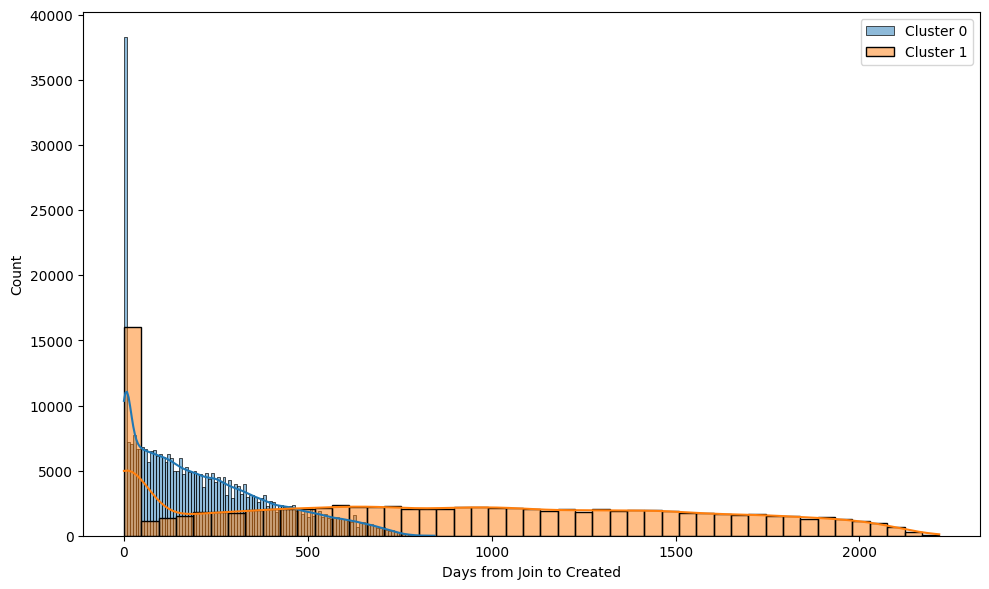

In [41]:
# 'first_join_date'와 'created_at'를 datetime 형식으로 변환합니다
filtered['first_join_date'] = pd.to_datetime(filtered['first_join_date'])
filtered['created_at'] = pd.to_datetime(filtered['created_at'])

# 타임존을 일치시키기 위해 'first_join_date'와 'created_at'의 타임존을 조정합니다
filtered['first_join_date'] = filtered['first_join_date'].dt.tz_localize(None)
filtered['created_at'] = filtered['created_at'].dt.tz_localize(None)

# 클러스터별로 데이터를 분할합니다
cluster_0 = filtered[filtered['cluster'] == 0]
cluster_1 = filtered[filtered['cluster'] == 1]

# 클러스터별 'first_join_date'와 'created_at'의 차이를 계산합니다
cluster_0['join_to_created_days'] = (cluster_0['created_at'] - cluster_0['first_join_date']).dt.days
cluster_1['join_to_created_days'] = (cluster_1['created_at'] - cluster_1['first_join_date']).dt.days

# 'join_to_created_days'를 시각화합니다
plt.figure(figsize=(10, 6))
sns.histplot(data=cluster_0, x='join_to_created_days', label='Cluster 0', kde=True)
sns.histplot(data=cluster_1, x='join_to_created_days', label='Cluster 1', kde=True)
plt.xlabel('Days from Join to Created')
plt.legend()
plt.tight_layout()
plt.show()

In [42]:
# 'cluster' 컬럼 이름을 'churn'으로 변경합니다
filtered.rename(columns={'cluster': 'churn'}, inplace=True)

# 'churn' 컬럼 내용물을 1은 'Remnant', 0은 'Secession'로 변경합니다
filtered['churn'] = filtered['churn'].apply(lambda x: 'Remnant' if x == 1 else 'Secession')

# 변경된 데이터프레임을 CSV 파일로 내보냅니다
filtered.to_csv('transation_with_churn.csv', index=False)